In [7]:
import os
import kagglehub
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

In [8]:

# =========================
# 0. Download and Extract Dataset
# =========================

# Download dataset using kagglehub
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces", force_download=True)
print("Path to dataset files:", path)

# Define your target folder
target_path = "/content/colab"
os.makedirs(target_path, exist_ok=True)

def copytree(src, dst):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            os.makedirs(d, exist_ok=True)
            copytree(s, d)
        else:
            shutil.copy2(s, d)

copytree(path, target_path)
print("Dataset extracted to:", target_path)

Path to dataset files: /kaggle/input/140k-real-and-fake-faces
Dataset extracted to: /content/colab


In [9]:

# =========================
# 1. Prepare Dataset Splits
# =========================

DATA_ROOT = os.path.join(target_path, 'real_vs_fake', 'real-vs-fake', 'train')
WILD_ROOT = '/content/wild'  # Place wild images here for OOD eval (optional)
CLASSES = ['real', 'fake']
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png')

def extract_identity(fname):
    # Example: 'ID123_img1.jpg' → 'ID123'
    return os.path.basename(fname).split('_')[0]

def collect_images():
    entries = []
    for label in CLASSES:
        folder = os.path.join(DATA_ROOT, label)
        if not os.path.isdir(folder):
            continue
        for fname in os.listdir(folder):
            if fname.lower().endswith(IMG_EXTENSIONS):
                fullpath = os.path.join(folder, fname)
                identity = extract_identity(fname)
                entries.append({'path': fullpath, 'label': label, 'identity': identity})
    return entries

entries = collect_images()
identities = list(set(e['identity'] for e in entries))

# Split identities, not images! (prevents leakage)
train_ids, test_ids = train_test_split(identities, test_size=0.15, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)
def filter_by_ids(entries, ids):
    return [e for e in entries if e['identity'] in ids]

train_entries = filter_by_ids(entries, train_ids)
val_entries   = filter_by_ids(entries, val_ids)
test_entries  = filter_by_ids(entries, test_ids)

print(f"Train: {len(train_entries)}, Val: {len(val_entries)}, Test: {len(test_entries)}")


Train: 76500, Val: 8500, Test: 15000


In [10]:

# =========================
# 2. Dataset & Augmentation
# =========================

class FacesDataset(Dataset):
    def __init__(self, entries, class_map, transform=None):
        self.entries = entries
        self.class_map = class_map
        self.transform = transform

    def __len__(self): return len(self.entries)

    def __getitem__(self, idx):
        row = self.entries[idx]
        img = Image.open(row['path']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.class_map[row['label']]
        return img, label

# Augmentation pipeline (strong for train)
mean, std = [0.5]*3, [0.5]*3
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomResizedCrop(128, scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.2)),
    transforms.Normalize(mean, std),
])
val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

class_map = {c: i for i, c in enumerate(CLASSES)}
inv_class_map = {v: k for k, v in class_map.items()}

# Loaders
batch_size = 32
train_ds = FacesDataset(train_entries, class_map, train_transform)
val_ds   = FacesDataset(val_entries, class_map, val_transform)
test_ds  = FacesDataset(test_entries, class_map, val_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# Optional: OOD/Wild loader
if os.path.isdir(WILD_ROOT):
    wild_imgs = glob(os.path.join(WILD_ROOT, '*'))
    wild_entries = [{'path': f, 'label': 'unknown', 'identity': 'wild'} for f in wild_imgs if f.lower().endswith(IMG_EXTENSIONS)]
    wild_ds = FacesDataset(wild_entries, class_map, val_transform)
    wild_loader = DataLoader(wild_ds, batch_size=1, shuffle=False)

In [11]:
# =========================
# 3. Simple CNN Model
# =========================

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(128*16*16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # [B,32,64,64]
        x = self.pool(F.relu(self.conv2(x)))    # [B,64,32,32]
        x = self.pool(F.relu(self.conv3(x)))    # [B,128,16,16]
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [12]:
# =========================
# 4. Training Loop
# =========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=len(CLASSES), dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, model, criterion, optimizer=None):
    model.train() if optimizer else model.eval()
    epoch_loss, correct, total = 0, 0, 0
    y_true, y_pred, y_prob = [], [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        probs = F.softmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().detach().numpy())
        correct += (preds==labels).sum().item()
        total += imgs.size(0)
    avg_loss = epoch_loss / total
    acc = correct / total
    return avg_loss, acc, np.array(y_true), np.array(y_pred), np.array(y_prob)

EPOCHS = 5
train_losses, val_losses, val_accs, val_f1s = [], [], [], []
for epoch in range(EPOCHS):
    tr_loss, tr_acc, _, _, _ = run_epoch(train_loader, model, criterion, optimizer)
    val_loss, val_acc, y_true, y_pred, y_prob = run_epoch(val_loader, model, criterion)
    val_f1 = f1_score(y_true, y_pred, average='macro')
    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)
    print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss={tr_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")


Epoch 1/5: Train Loss=0.6619, Val Loss=0.5940, Val Acc=0.6826, Val F1=0.6818
Epoch 2/5: Train Loss=0.5933, Val Loss=0.5072, Val Acc=0.7535, Val F1=0.7517
Epoch 3/5: Train Loss=0.5559, Val Loss=0.4789, Val Acc=0.7722, Val F1=0.7720
Epoch 4/5: Train Loss=0.5308, Val Loss=0.4758, Val Acc=0.7736, Val F1=0.7727
Epoch 5/5: Train Loss=0.5177, Val Loss=0.4677, Val Acc=0.7767, Val F1=0.7755


In [13]:
import torch

# Save the complete model (architecture + weights)
torch.save(model, "face_cnn_model_complete.pth")
print("✅ Full model saved to face_cnn_model_complete.pth")


✅ Full model saved to face_cnn_model_complete.pth


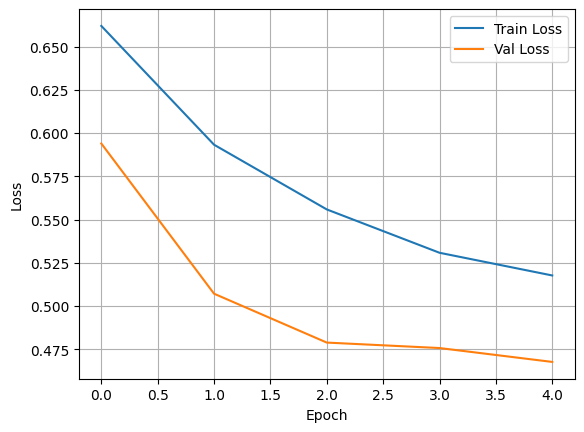

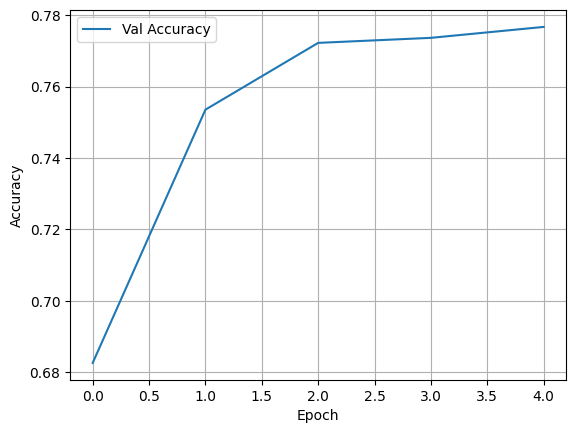

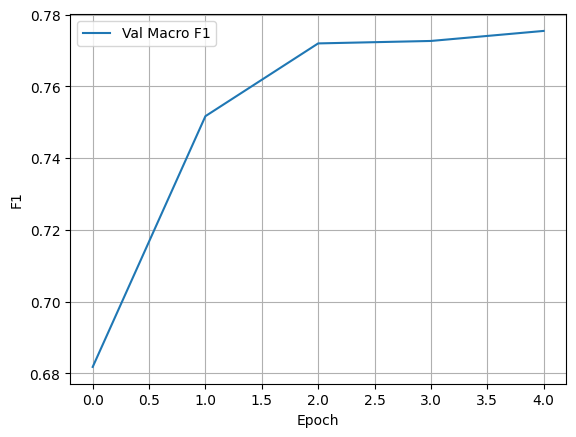

In [14]:
# =========================
# 5. Plotting Metrics
# =========================

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(); plt.show()

plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(); plt.show()

plt.plot(val_f1s, label='Val Macro F1')
plt.xlabel('Epoch'); plt.ylabel('F1'); plt.legend(); plt.grid(); plt.show()


Test Loss: 0.4667 | Test Accuracy: 0.7795 | Macro F1: 0.7777
              precision    recall  f1-score   support

        real       0.83      0.70      0.76      7421
        fake       0.74      0.86      0.80      7579

    accuracy                           0.78     15000
   macro avg       0.79      0.78      0.78     15000
weighted avg       0.79      0.78      0.78     15000



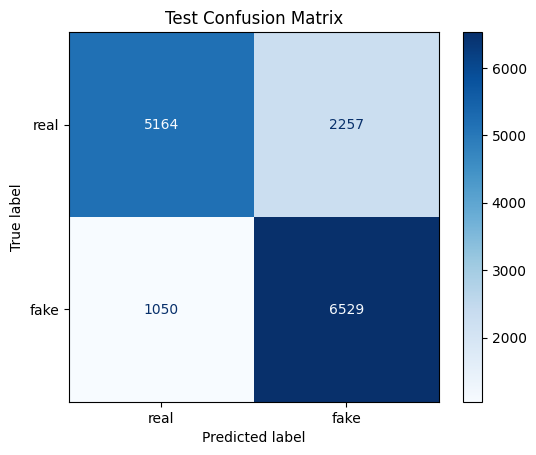

In [15]:
# =========================
# 6. Evaluation & Confusion Matrix
# =========================

test_loss, test_acc, y_true, y_pred, y_prob = run_epoch(test_loader, model, criterion)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Macro F1: {f1_score(y_true, y_pred, average='macro'):.4f}")
print(classification_report(y_true, y_pred, target_names=CLASSES))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(cmap='Blues')
plt.title("Test Confusion Matrix")
plt.show()

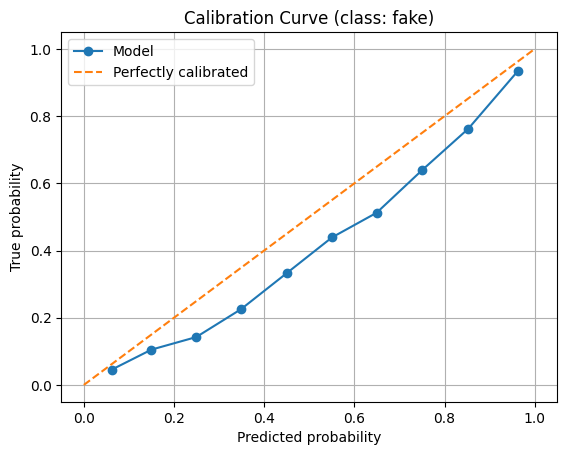

In [16]:
# =========================
# 7. Calibration Curve
# =========================

prob_true, prob_pred = calibration_curve(y_true == 1, y_prob[:,1], n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0,1],[0,1],'--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve (class: %s)' % CLASSES[1])
plt.legend(); plt.grid(); plt.show()


In [17]:
# =========================
# 8. Wild/OOD Eval (Optional)
# =========================

if os.path.isdir(WILD_ROOT):
    model.eval()
    print("\nPredicting on WILD images (unseen):")
    for imgs, _ in wild_loader:
        imgs = imgs.to(device)
        with torch.no_grad():
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
            pred = probs.argmax()
        img_np = imgs[0].permute(1,2,0).cpu().numpy() * std + mean
        plt.imshow(np.clip(img_np, 0, 1))
        plt.title(f"Pred: {CLASSES[pred]} (p={probs[pred]:.2f}) | Probs: {probs}")
        plt.axis('off'); plt.show()

True Label: real, Predicted: fake, Probabilities: [0.3474564  0.65254354]


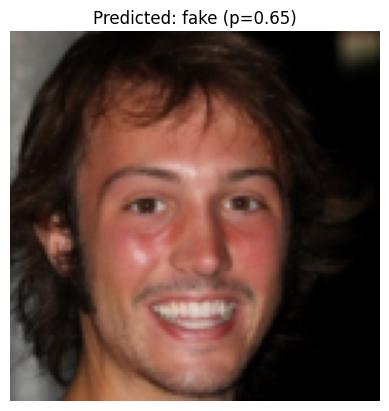

In [18]:
# Testing on one random sample from test set
model.eval()
sample_img, sample_label = random.choice(test_ds)

# Add batch dimension and move to device
input_img = sample_img.unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_img)
    probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
    pred_class = probs.argmax()

print(f"True Label: {inv_class_map[sample_label]}, Predicted: {inv_class_map[pred_class]}, Probabilities: {probs}")

# Show image
img_np = sample_img.permute(1, 2, 0).numpy() * std + mean  # Unnormalize
img_np = np.clip(img_np, 0, 1)
plt.imshow(img_np)
plt.title(f"Predicted: {inv_class_map[pred_class]} (p={probs[pred_class]:.2f})")
plt.axis('off')
plt.show()


Image 1: True Label: fake, Predicted: fake, Confidence: 0.99


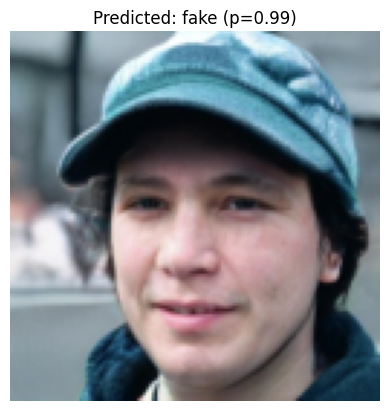

Image 2: True Label: real, Predicted: fake, Confidence: 0.99


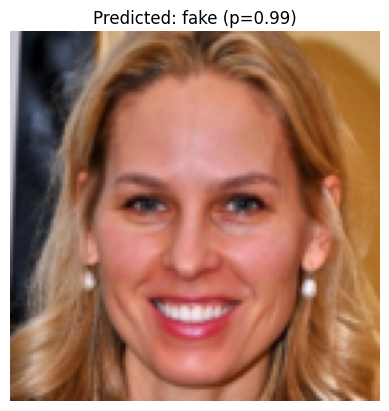

Image 3: True Label: real, Predicted: fake, Confidence: 0.94


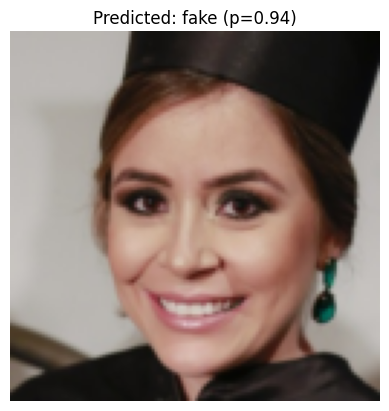

Image 4: True Label: real, Predicted: real, Confidence: 0.85


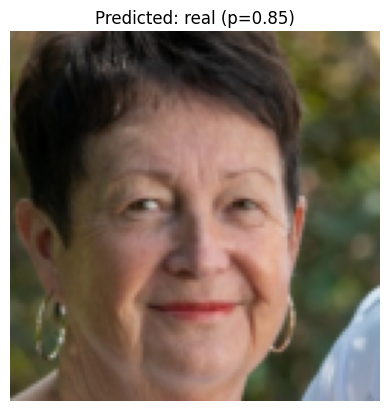

Image 5: True Label: real, Predicted: real, Confidence: 0.57


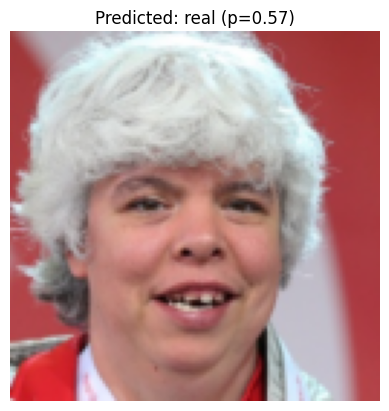

In [19]:
model.eval()

for i in range(5):
    img, label = random.choice(test_ds)  # Get random image and true label
    input_img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_img)
        probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
        pred_class = probs.argmax()

    # Unnormalize for display
    img_np = img.permute(1, 2, 0).numpy() * std + mean
    img_np = np.clip(img_np, 0, 1)

    print(f"Image {i+1}: True Label: {inv_class_map[label]}, Predicted: {inv_class_map[pred_class]}, Confidence: {probs[pred_class]:.2f}")
    plt.imshow(img_np)
    plt.title(f"Predicted: {inv_class_map[pred_class]} (p={probs[pred_class]:.2f})")
    plt.axis('off')
    plt.show()


Predicted: real (Confidence: 0.79)


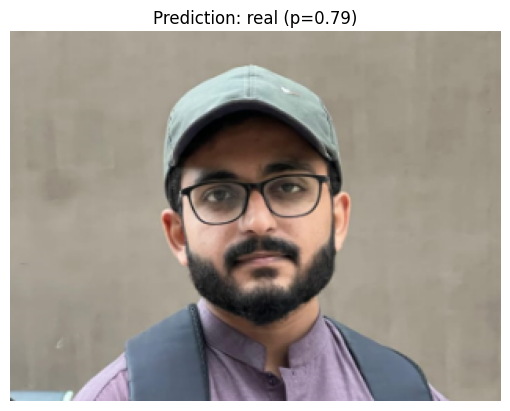

In [23]:
def predict_image_from_path(img_path):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    img_t = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
        pred_class = probs.argmax()

    print(f"Predicted: {inv_class_map[pred_class]} (Confidence: {probs[pred_class]:.2f})")
    plt.imshow(img)
    plt.title(f"Prediction: {inv_class_map[pred_class]} (p={probs[pred_class]:.2f})")
    plt.axis('off')
    plt.show()

# Now call the function with your image path as a string
predict_image_from_path('/content/shaheerreal.png')


✅ Model loaded successfully on cuda


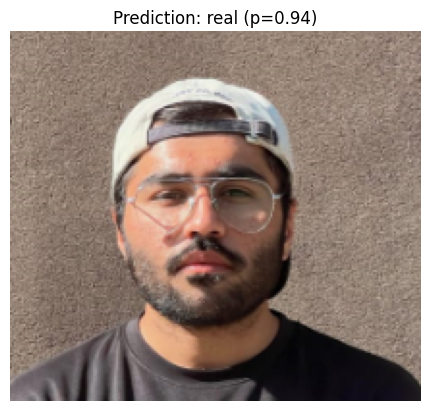

Predicted Class: real, Confidence: 0.94


In [27]:
# =========================
# FACE CNN - Inference Script
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# =========================
# 1. Define same SimpleCNN class used in training
# =========================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # [B,32,64,64]
        x = self.pool(F.relu(self.conv2(x)))    # [B,64,32,32]
        x = self.pool(F.relu(self.conv3(x)))    # [B,128,16,16]
        x = x.view(x.size(0), -1)               # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# =========================
# 2. Load the trained full model
# =========================
model_path = "/content/face_cnn_model_complete.pth"  # Path to your saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()
print("✅ Model loaded successfully on", device)

# =========================
# 3. Define preprocessing (must match validation transform from training)
# =========================
mean, std = [0.5] * 3, [0.5] * 3
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

CLASSES = ['real', 'fake']  # Same class order as training

# =========================
# 4. Prediction function
# =========================
def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img_t = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_t)
        probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
        pred_class = probs.argmax()

    plt.imshow(img)
    plt.title(f"Prediction: {CLASSES[pred_class]} (p={probs[pred_class]:.2f})")
    plt.axis('off')
    plt.show()

    return CLASSES[pred_class], probs[pred_class]

# =========================
# 5. Test with an image
# =========================
# In Colab, you can upload an image using:
# from google.colab import files
# uploaded = files.upload()
# img_path = list(uploaded.keys())[0]

img_path = "/content/realharis.png"  # Change this to your image path
pred_label, confidence = predict_image(img_path)
print(f"Predicted Class: {pred_label}, Confidence: {confidence:.2f}")


In [29]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import gradio as gr

# Define your classes
CLASSES = ['real', 'fake']

# Recreate the SimpleCNN architecture exactly as it was when saving
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # for 224x224 input
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Allowlist SimpleCNN so torch.load can unpickle it
torch.serialization.add_safe_globals([SimpleCNN])

# Load model
model_path = "/content/face_cnn_model_complete.pth"
model = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
model.eval()

# Transform for input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # match model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Prediction function
def predict_image(image):
    image = Image.fromarray(image).convert("RGB")
    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        class_label = CLASSES[predicted.item()]
        confidence = torch.softmax(outputs, dim=1)[0][predicted.item()].item()

    return {class_label: float(confidence)}

# Create Gradio Interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy", label="Upload Face Image"),
    outputs=gr.Label(num_top_classes=2, label="Prediction"),
    title="Real vs Fake Face Detection",
    description="Upload a face image and the model will predict if it's real or fake."
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://471b3a53899c004cfc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [30]:
%%writefile app.py
import streamlit as st
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load model
model = torch.load("face_cnn_model_complete.pth", map_location="cpu")
model.eval()

# Define transform (same as training)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Define classes (must match training)
CLASSES = ["real", "fake"]  # change this to your actual class names

# Streamlit UI
st.title("Face CNN Prediction App")
st.write("Upload an image and get prediction")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        label = CLASSES[predicted.item()]

    st.write(f"Prediction: **{label}**")


Writing app.py
